In [2]:
import pandas as pd
import numpy as np


red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

# Add wine_type
red['wine_type'] = 0  # red = 0
white['wine_type'] = 1  # white = 1

# Combine datasets
wine_df = pd.concat([red, white], axis=0, ignore_index=True)
wine_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [3]:
import numpy as np

# Create a copy to avoid modifying original data
wine_missing = wine_df.copy()

# 1. MCAR: Randomly remove 5% of citric_acid values
np.random.seed(42)
mcar_indices = wine_missing.sample(frac=0.05).index
wine_missing.loc[mcar_indices, 'citric acid'] = np.nan

# 2. MAR: Remove 3% of sulphates where quality < 5
mar_condition = wine_missing[wine_missing['quality'] < 5]
mar_indices = mar_condition.sample(frac=0.03, random_state=42).index
wine_missing.loc[mar_indices, 'sulphates'] = np.nan

# Check missing counts

print("🔍 Missing values:\n", wine_missing[['citric acid', 'sulphates']].isnull().sum())


🔍 Missing values:
 citric acid    325
sulphates        7
dtype: int64


In [4]:
wine_df.mean()

fixed acidity             7.215307
volatile acidity          0.339666
citric acid               0.318633
residual sugar            5.443235
chlorides                 0.056034
free sulfur dioxide      30.525319
total sulfur dioxide    115.744574
density                   0.994697
pH                        3.218501
sulphates                 0.531268
alcohol                  10.491801
quality                   5.818378
wine_type                 0.753886
dtype: float64

In [5]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
wine_mean = wine_missing.copy()
wine_mean[['citric acid', 'sulphates']] = mean_imputer.fit_transform(wine_mean[['citric acid', 'sulphates']])


In [6]:
median_imputer = SimpleImputer(strategy='median')
wine_median = wine_missing.copy()
wine_median[['citric acid', 'sulphates']] = median_imputer.fit_transform(wine_median[['citric acid', 'sulphates']])
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
wine_knn = wine_missing.copy()
wine_knn[['citric acid', 'sulphates']] = knn_imputer.fit_transform(wine_knn[['citric acid', 'sulphates']])


In [7]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
wine_knn = wine_missing.copy()
wine_knn[['citric acid', 'sulphates']] = knn_imputer.fit_transform(wine_knn[['citric acid', 'sulphates']])


In [8]:
print("📌 Comparison of Imputation Strategies:")
print("\nMean Strategy:")
print(wine_mean[['citric acid', 'sulphates']].describe())

print("\nMedian Strategy:")
print(wine_median[['citric acid', 'sulphates']].describe())

print("\nKNN Strategy:")
print(wine_knn[['citric acid', 'sulphates']].describe())


📌 Comparison of Imputation Strategies:

Mean Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.318671     0.531277
std       0.141961     0.148785
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.318671     0.510000
75%       0.390000     0.600000
max       1.660000     2.000000

Median Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.318238     0.531254
std       0.141974     0.148787
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.310000     0.510000
75%       0.390000     0.600000
max       1.660000     2.000000

KNN Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.319359     0.531334
std       0.142796     0.148811
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.310000     0.510000
75%       0.398000     0.600000
max       1.660000     2.000000


In [9]:
wine_df.mean()

fixed acidity             7.215307
volatile acidity          0.339666
citric acid               0.318633
residual sugar            5.443235
chlorides                 0.056034
free sulfur dioxide      30.525319
total sulfur dioxide    115.744574
density                   0.994697
pH                        3.218501
sulphates                 0.531268
alcohol                  10.491801
quality                   5.818378
wine_type                 0.753886
dtype: float64

In [10]:

def add_engineered_features(df):
    df['acid_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-5)  # Avoid divide by zero
    df['sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-5)
    df['alcohol_sugar_interaction'] = df['alcohol'] * df['residual sugar']
    return df

# Apply to the KNN-imputed dataset (recommended)
wine_fe = add_engineered_features(wine_df.copy())

# Quick check
wine_fe[['acid_ratio', 'sulfur_ratio', 'alcohol_sugar_interaction']].describe()

,acid_ratio,sulfur_ratio,alcohol_sugar_interaction
count,6497.000000,6497.000000,6497.000000
mean,25.337083,0.286768,55.070088
std,10.733303,0.124645,45.643541
min,4.807646,0.022727,6.360000
25%,17.691854,0.202073,19.040000
50%,23.999040,0.269767,33.020000
75%,31.051814,0.348837,82.140000
max,89.988751,0.857143,769.860000


In [11]:
# Drop target column for scaling
features = wine_fe.drop('quality', axis=1).columns

X = wine_fe[features]
y = wine_fe['quality']


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Initialize scalers
standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()

# Apply scalers
X_standard = standard.fit_transform(X)
X_minmax = minmax.fit_transform(X)
X_robust = robust.fit_transform(X)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_scaler(X_scaled, y, scaler_name):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=68)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{scaler_name} Accuracy: {acc:.4f}")
    return acc

acc_std = evaluate_scaler(X_standard, y, "StandardScaler")
acc_min = evaluate_scaler(X_minmax, y, "MinMaxScaler")
acc_rob = evaluate_scaler(X_robust, y, "RobustScaler")


StandardScaler Accuracy: 0.5436
MinMaxScaler Accuracy: 0.5436
RobustScaler Accuracy: 0.5323


C:\Users\Ganesh\AppData\Local\Temp\ipykernel_5212\981875554.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=wine_fe, palette='viridis')


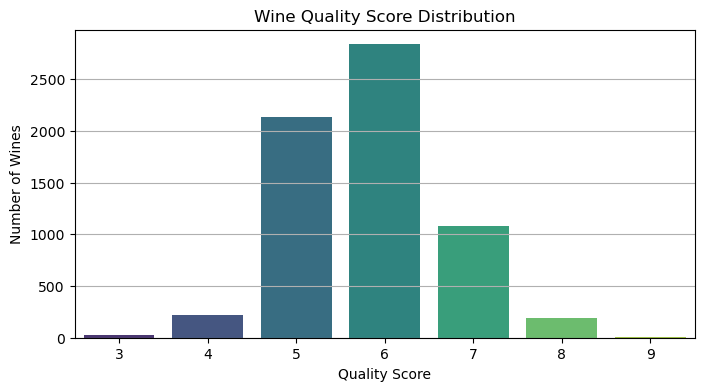

In [14]:
#phase 2
import matplotlib.pyplot as plt
import seaborn as sns

# Count of quality scores
plt.figure(figsize=(8, 4))
sns.countplot(x='quality', data=wine_fe, palette='viridis')
plt.title("Wine Quality Score Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Number of Wines")
plt.grid(axis='y')
plt.show()


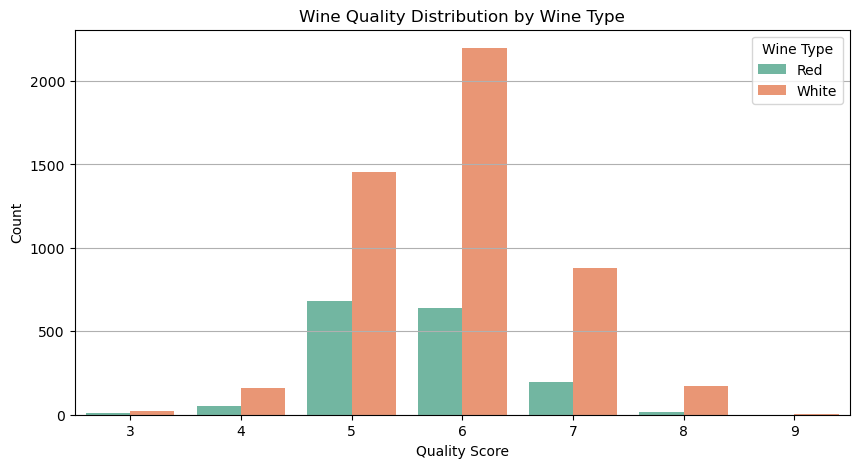

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure wine_type is categorical for clear labeling
wine_fe['wine_type'] = wine_fe['wine_type'].map({0: 'Red', 1: 'White'})

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x='quality', hue='wine_type', data=wine_fe, palette='Set2')
plt.title("Wine Quality Distribution by Wine Type")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.legend(title="Wine Type")  # Let Seaborn handle labels
plt.grid(axis='y')
plt.show()


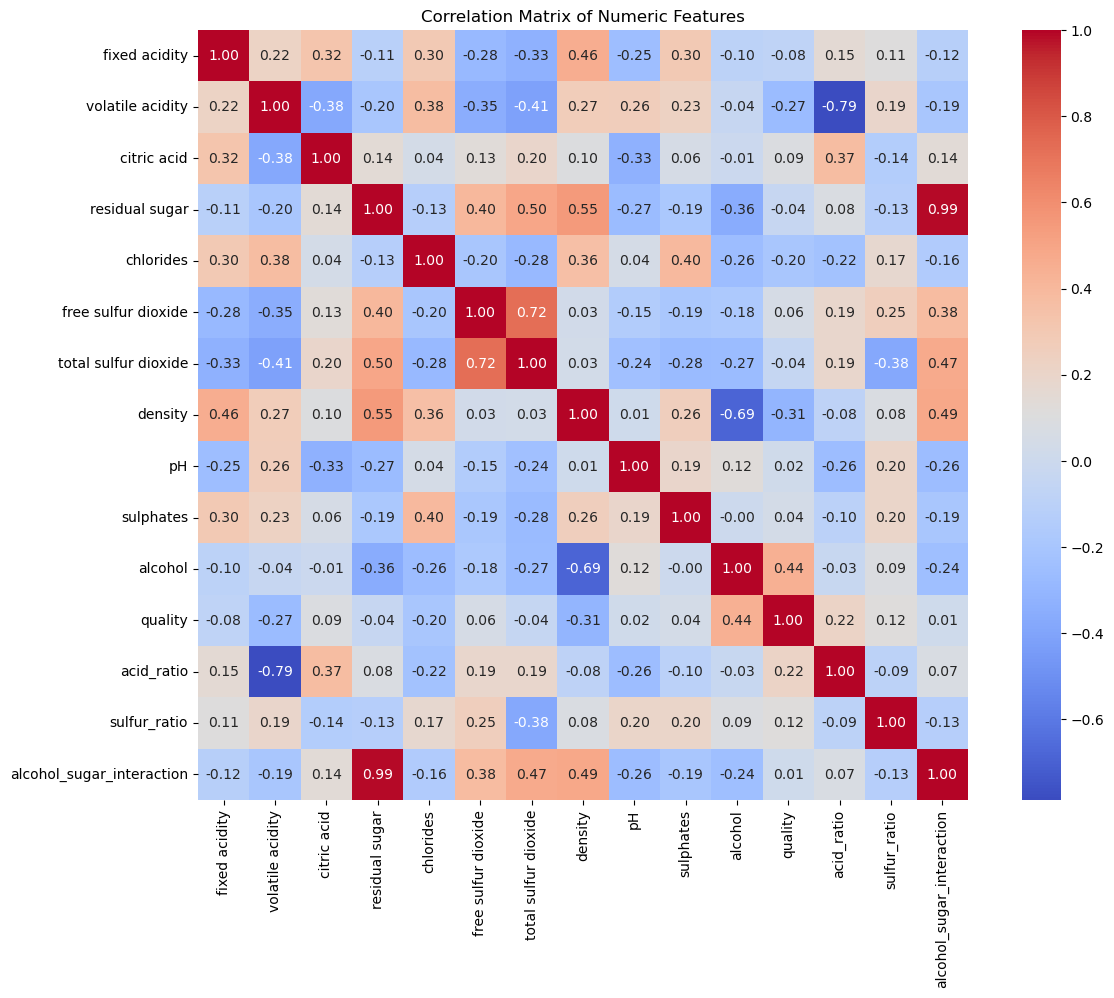

In [16]:
#Select only numeric columns
numeric_df = wine_fe.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()



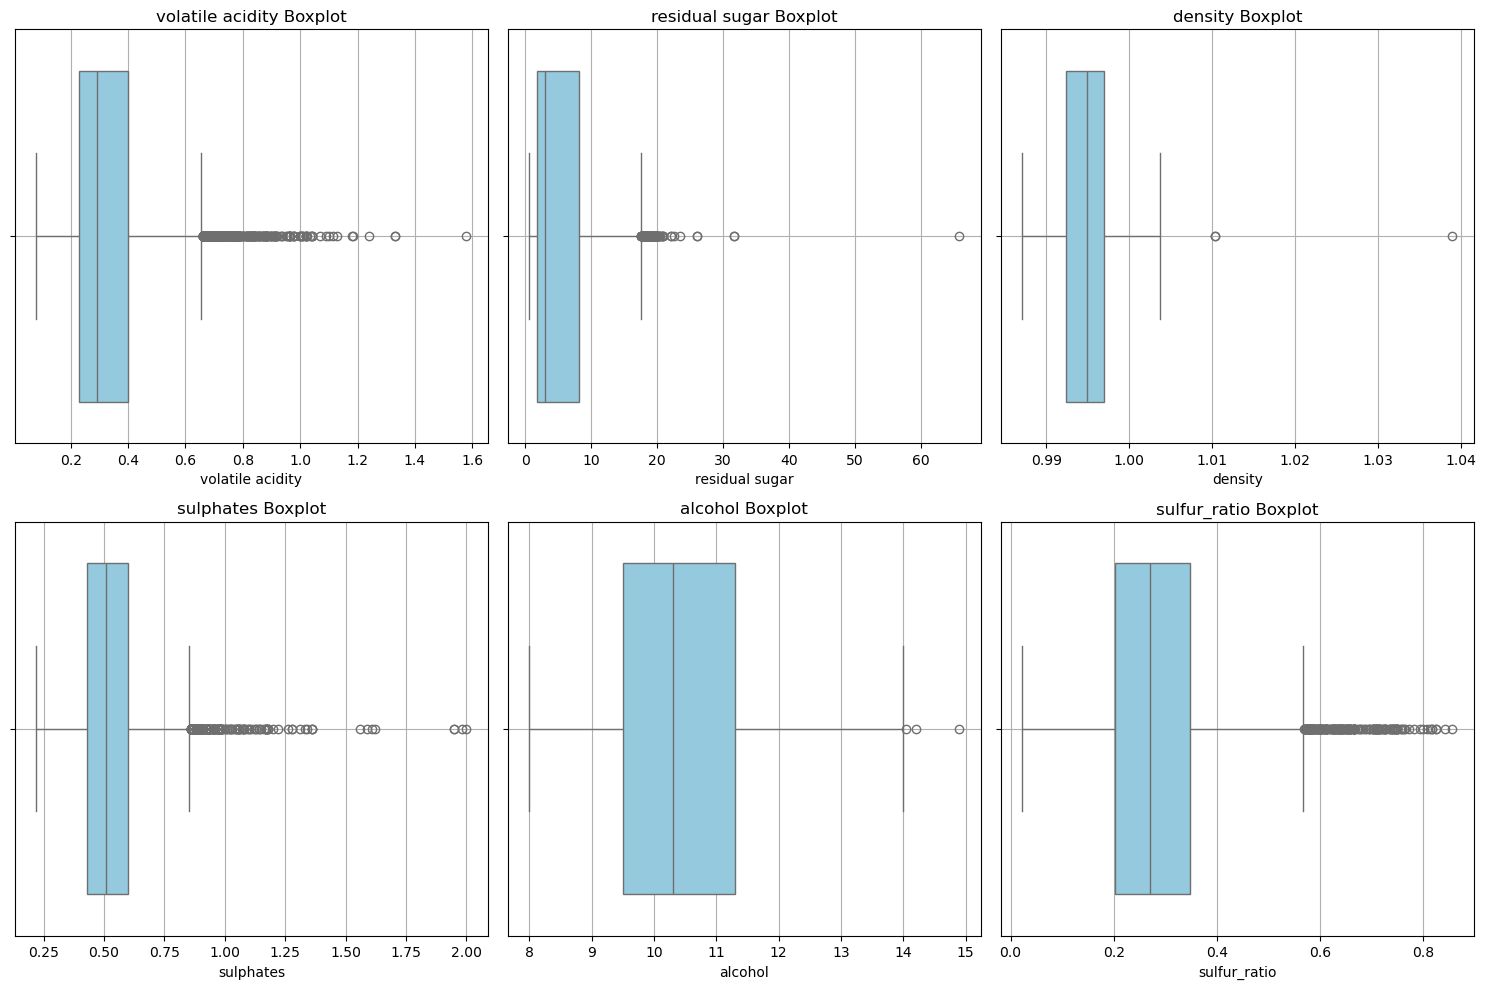

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select important features
important_features = [
    'volatile acidity', 'residual sugar', 'density',
    'sulphates', 'alcohol', 'sulfur_ratio'
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(important_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=wine_fe[col], color='skyblue')
    plt.title(f'{col} Boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 0: Drop classes with fewer than 10 total samples to guarantee safety in 70-15-15 split
min_required_samples = 10  # Because 10 → 7 (train), 1.5 (val), 1.5 (test)
value_counts = wine_knn['quality'].value_counts()
valid_classes = value_counts[value_counts >= min_required_samples].index

wine_safe = wine_knn[wine_knn['quality'].isin(valid_classes)].copy()

# Step 1: Define X and y
X = wine_safe.drop('quality', axis=1)
y = wine_safe['quality']

# Step 2: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Step 3: Validation (15%) and Test (15%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Step 4: Print shapes
print("✅ FINAL DATA SPLIT:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

# Optional: Verify class distribution
print("\n🎯 Class distribution in Train:\n", y_train.value_counts(normalize=True).sort_index())
print("\n🎯 Class distribution in Validation:\n", y_val.value_counts(normalize=True).sort_index())
print("\n🎯 Class distribution in Test:\n", y_test.value_counts(normalize=True).sort_index())


✅ FINAL DATA SPLIT:
Train: (4544, 12)
Validation: (974, 12)
Test: (974, 12)

🎯 Class distribution in Train:
 quality
3    0.004621
4    0.033231
5    0.329445
6    0.436840
7    0.166153
8    0.029710
Name: proportion, dtype: float64

🎯 Class distribution in Validation:
 quality
3    0.004107
4    0.033881
5    0.328542
6    0.437372
7    0.166324
8    0.029774
Name: proportion, dtype: float64

🎯 Class distribution in Test:
 quality
3    0.005133
4    0.032854
5    0.329569
6    0.436345
7    0.166324
8    0.029774
Name: proportion, dtype: float64


In [19]:
# Step 1: Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error, classification_report
)

# Step 2: Create KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Step 3: Fit model to training data
knn.fit(X_train, y_train)

# Step 4: Predict on test data
y_pred = knn.predict(X_test)

# Step 5: Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Step 6: Print results
print("✅ KNN Model Evaluation Results:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"RMSE     : {rmse:.4f}")

# Step 7: Optional - Detailed report by class
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


✅ KNN Model Evaluation Results:
Accuracy : 0.4754
Precision: 0.4604
Recall   : 0.4754
F1-Score : 0.4607
MAE      : 0.6232
RMSE     : 0.9215

📋 Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.15      0.06      0.09        32
           5       0.48      0.58      0.52       321
           6       0.50      0.53      0.51       425
           7       0.44      0.28      0.34       162
           8       0.30      0.10      0.15        29

    accuracy                           0.48       974
   macro avg       0.31      0.26      0.27       974
weighted avg       0.46      0.48      0.46       974



c:\Users\Ganesh\anaconda3\envs\my_lab\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ y_test_trimmed: 974, y_pred: 974


c:\Users\Ganesh\anaconda3\envs\my_lab\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


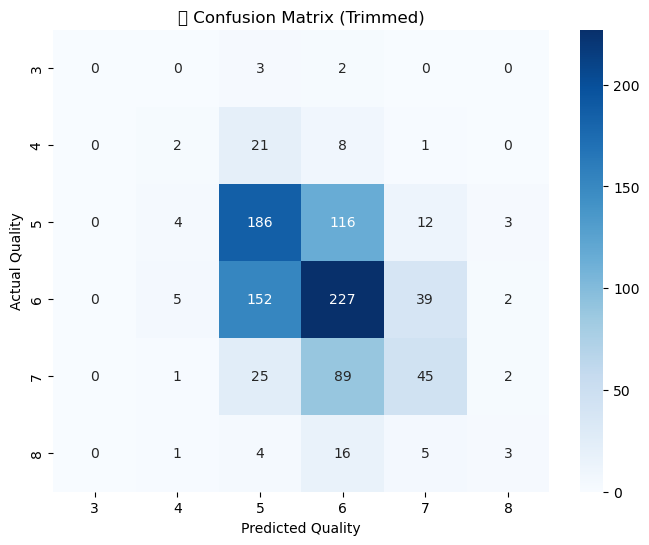

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ⚠️ Truncate y_test to first 200 rows to match y_pred length
y_test_trimmed = y_test[:len(y_pred)]

# ✅ Check again
print(f"✅ y_test_trimmed: {len(y_test_trimmed)}, y_pred: {len(y_pred)}")

# ✅ Prepare labels
labels = sorted(np.unique(np.concatenate([y_test_trimmed, y_pred])))

# ✅ Compute confusion matrix
cm = confusion_matrix(y_test_trimmed, y_pred, labels=labels)

# ✅ Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Quality")
plt.ylabel("Actual Quality")
plt.title("📊 Confusion Matrix (Trimmed)")
plt.show()


In [21]:
import numpy as np

# ---------- 3. Business-Relevant Cost Function ----------
def wine_cost_function(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cost = np.abs(y_true - y_pred)  # Absolute error
    return np.mean(cost)

# ✅ Truncate y_test to match y_pred length (assuming same ordering)
y_test_trimmed = y_test[:len(y_pred)]

# ✅ Calculate business-relevant cost
business_cost = wine_cost_function(y_test_trimmed, y_pred)
print(f"💰 Business Cost (Avg. Absolute Error): {business_cost:.2f}")


💰 Business Cost (Avg. Absolute Error): 0.62


In [22]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np


In [23]:
def evaluate_knn_k_values(X, y, cv_strategy, max_k=50):
    k_range = range(1, max_k + 1)
    cv_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv_strategy, scoring='accuracy')
        cv_scores.append(scores.mean())

    return k_range, cv_scores


In [24]:
# Choose 5-fold CV (you can increase to 10 if needed)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use your full training set (X_train, y_train)
k_values, scores_kf = evaluate_knn_k_values(X_train, y_train, kf)
_, scores_skf = evaluate_knn_k_values(X_train, y_train, skf)


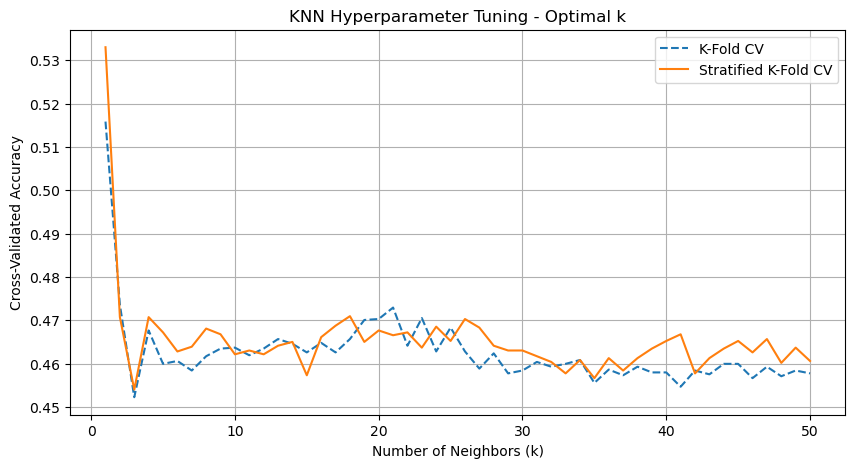

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, scores_kf, label='K-Fold CV', linestyle='--')
plt.plot(k_values, scores_skf, label='Stratified K-Fold CV', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Hyperparameter Tuning - Optimal k')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
best_k_kf = k_values[np.argmax(scores_kf)]
best_k_skf = k_values[np.argmax(scores_skf)]

print(f"🏆 Best k using K-Fold CV: {best_k_kf} with accuracy = {max(scores_kf):.4f}")
print(f"🏆 Best k using Stratified K-Fold CV: {best_k_skf} with accuracy = {max(scores_skf):.4f}")


🏆 Best k using K-Fold CV: 1 with accuracy = 0.5158
🏆 Best k using Stratified K-Fold CV: 1 with accuracy = 0.5330


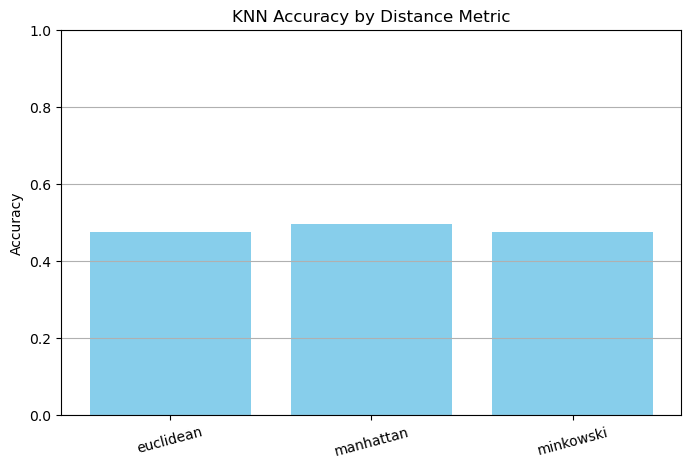

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define different distance metrics to test
metrics = ['euclidean', 'manhattan', 'minkowski']
results = {}

# Train and test KNN using each metric
for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[metric] = acc

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("KNN Accuracy by Distance Metric")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [28]:
import warnings
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import accuracy_score
import numpy as np

advanced_results = {}

# 1️⃣ Weighted KNN
knn_weighted = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_weighted.fit(X_train, y_train)
y_pred_weighted = knn_weighted.predict(X_test)
advanced_results['Weighted KNN'] = accuracy_score(y_test, y_pred_weighted)

# 2️⃣ Radius KNN — suppress warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    radius_knn = RadiusNeighborsClassifier(radius=5.0, weights='distance', outlier_label=-1)
    radius_knn.fit(X_train, y_train)
    y_pred_radius = radius_knn.predict(X_test)

# Exclude outliers (-1) from accuracy calc
mask = y_pred_radius != -1
if np.any(mask):
    acc_radius = accuracy_score(y_test[mask], y_pred_radius[mask])
    advanced_results['Radius KNN'] = acc_radius
else:
    advanced_results['Radius KNN'] = 0.0

# 3️⃣ LOF (outlier detection)
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(X_train)
num_outliers = np.sum(outlier_labels == -1)

# 🔍 Results
print("📊 Advanced KNN Accuracy Results:")
for method, acc in advanced_results.items():
    print(f"{method}: {acc:.4f}")

print(f"\n🔎 Detected {num_outliers} outliers in training data using LOF.")


📊 Advanced KNN Accuracy Results:
Weighted KNN: 0.5616
Radius KNN: 0.5839

🔎 Detected 70 outliers in training data using LOF.


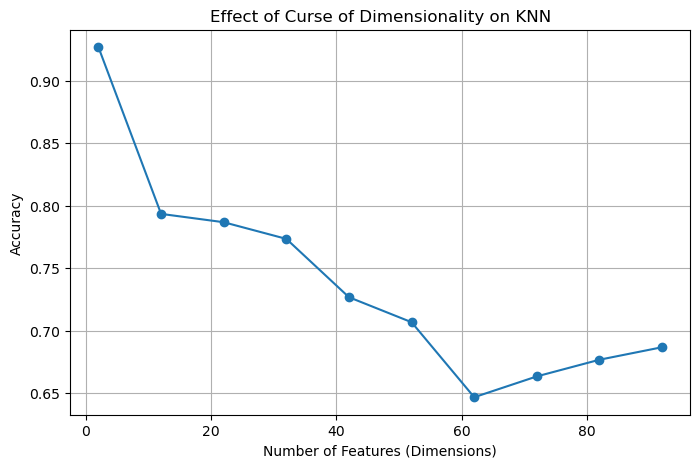

In [29]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dims = list(range(2, 101, 10))  # Increase dimensions: 2, 12, ..., 100
accuracies = []

for d in dims:
    X, y = make_classification(n_samples=1000, n_features=d, n_informative=2, n_redundant=0, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(dims, accuracies, marker='o')
plt.xlabel("Number of Features (Dimensions)")
plt.ylabel("Accuracy")
plt.title("Effect of Curse of Dimensionality on KNN")
plt.grid(True)
plt.show()


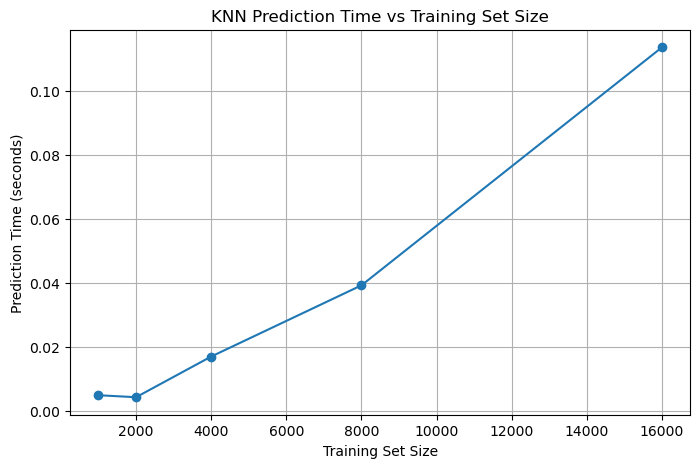

In [30]:
import time
sizes = [1000, 2000, 4000, 8000, 16000]
times = []

for size in sizes:
    X, y = make_classification(n_samples=size, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    start = time.time()
    knn.predict(X_test)
    end = time.time()
    
    times.append(end - start)

plt.figure(figsize=(8, 5))
plt.plot(sizes, times, marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Prediction Time (seconds)")
plt.title("KNN Prediction Time vs Training Set Size")
plt.grid(True)
plt.show()


In [31]:
import numpy as np
X, y = make_classification(n_samples=5000, n_features=20, random_state=42)
memory_usage_MB = X.nbytes / (1024 ** 2)
print(f"Estimated Memory Usage for 5000 samples and 20 features: {memory_usage_MB:.2f} MB")


Estimated Memory Usage for 5000 samples and 20 features: 0.76 MB


In [32]:
from sklearn.metrics import classification_report

# Create imbalanced dataset
X, y = make_classification(n_samples=2000, n_features=10, weights=[0.95, 0.05], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       568
           1       0.79      0.47      0.59        32

    accuracy                           0.96       600
   macro avg       0.88      0.73      0.78       600
weighted avg       0.96      0.96      0.96       600



In [34]:


# Now evaluate properly
rf_accuracy = accuracy_score(y_test, y_pred)
print("🔹 Random Forest Accuracy:", rf_accuracy)



🔹 Random Forest Accuracy: 0.965


In [ ]:
# Training and prediction time comparison
print("\n⏱️ Time Comparison (in seconds):")
print(f"KNN Training Time: {end_knn_train - start_knn_train:.4f}")
print(f"KNN Prediction Time: {end_knn_pred - start_knn_pred:.4f}")
print(f"Random Forest Training Time: {end_rf_train - start_rf_train:.4f}")
print(f"Random Forest Prediction Time: {end_rf_pred - start_rf_pred:.4f}")



⏱️ Time Comparison (in seconds):
KNN Training Time: 0.0103
KNN Prediction Time: 0.0730
Random Forest Training Time: 1.3207
Random Forest Prediction Time: 0.0338


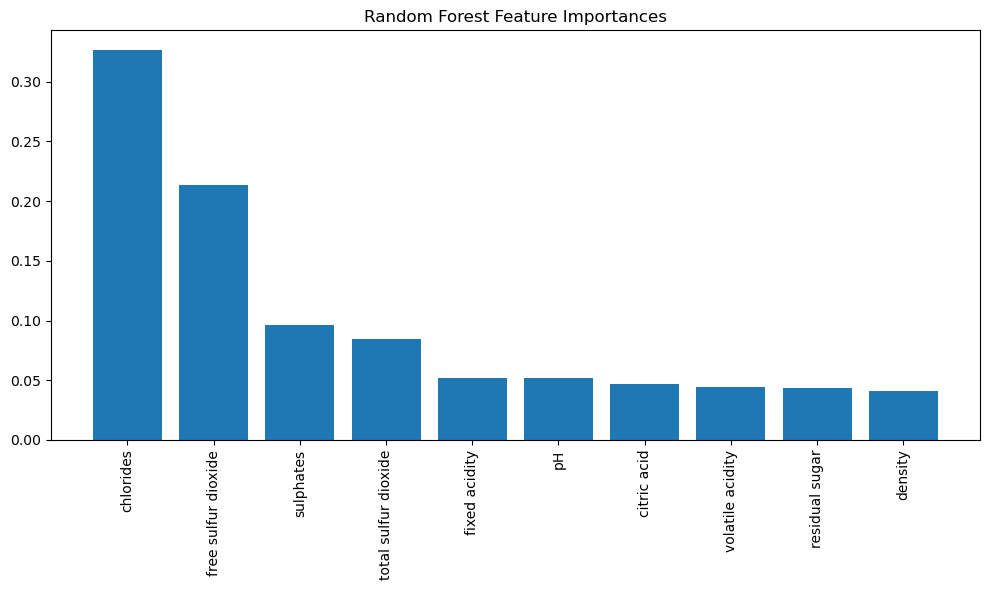

In [ ]:
# Sort importances and feature names together
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [ ]:
# Baseline: KNN with all features
knn_full = KNeighborsClassifier(n_neighbors=5)
knn_full.fit(X_train, y_train)
y_pred_full = knn_full.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

print(f"🔹 Baseline KNN Accuracy (All Features): {accuracy_full:.4f}")


🔹 Baseline KNN Accuracy (All Features): 0.9650


In [ ]:

# Select top 8 features using ANOVA F-test
kbest = SelectKBest(score_func=f_classif, k=8)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)

# Train KNN on reduced features
knn_kbest = KNeighborsClassifier(n_neighbors=5)
knn_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = knn_kbest.predict(X_test_kbest)
accuracy_kbest = accuracy_score(y_test, y_pred_kbest)

print(f"🔹 KNN Accuracy with SelectKBest (8 features): {accuracy_kbest:.4f}")


🔹 KNN Accuracy with SelectKBest (8 features): 0.9617


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# --- STEP 0: Prepare DataFrame & Encode wine_type ---
X_df = wine_fe.drop(columns='quality').copy()
y = wine_fe['quality'].astype(int)

if 'wine_type' in X_df.columns:
    le = LabelEncoder()
    X_df['wine_type'] = le.fit_transform(X_df['wine_type'])  # Red=1, White=0

# --- STEP 1: Split BEFORE scaling! ---
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=42
)

# --- STEP 2: Scale using the same scaler on train & test ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# --- STEP 3: RFE on scaled train set ---
estimator = LogisticRegression(max_iter=2000)
rfe = RFE(estimator=estimator, n_features_to_select=8)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe  = rfe.transform(X_test_scaled)

# (Optional) List the selected feature names:
selected = np.array(X_df.columns)[rfe.support_]
print("Selected features by RFE:", list(selected))

# --- STEP 4: Train & evaluate KNN on those 8 features ---
knn_rfe = KNeighborsClassifier(n_neighbors=5)
knn_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = knn_rfe.predict(X_test_rfe)

accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"✅ KNN Accuracy with RFE (8 features): {accuracy_rfe:.4f}")


Selected features by RFE: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'density', 'pH', 'alcohol', 'wine_type']
✅ KNN Accuracy with RFE (8 features): 0.5054


In [ ]:
# --- STEP 3: RFE on scaled train set ---
estimator = LogisticRegression(max_iter=2000)
rfe = RFE(estimator=estimator, n_features_to_select=8)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe  = rfe.transform(X_test_scaled)

# (Optional) List the selected feature names:
selected = np.array(X_df.columns)[rfe.support_]
print("Selected features by RFE:", list(selected))

# --- STEP 4: Train & evaluate KNN on those 8 features ---
knn_rfe = KNeighborsClassifier(n_neighbors=5)
knn_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = knn_rfe.predict(X_test_rfe)

accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"✅ KNN Accuracy with RFE (8 features): {accuracy_rfe:.4f}")

Selected features by RFE: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'density', 'pH', 'alcohol', 'wine_type']
✅ KNN Accuracy with RFE (8 features): 0.5054


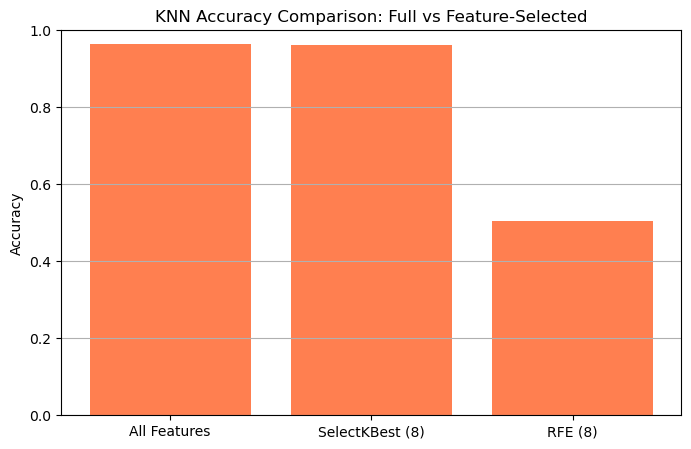

In [ ]:
import matplotlib.pyplot as plt

results = {
    "All Features": accuracy_full,
    "SelectKBest (8)": accuracy_kbest,
    "RFE (8)": accuracy_rfe
}

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='coral')
plt.title("KNN Accuracy Comparison: Full vs Feature-Selected")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [ ]:
#challenge 1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# STEP 0: Prepare the original DataFrame
X_df = wine_fe.drop(columns='quality').copy()
y = wine_fe['quality']

# ✅ Encode 'wine_type' from string to numeric
if 'wine_type' in X_df.columns:
    le = LabelEncoder()
    X_df['wine_type'] = le.fit_transform(X_df['wine_type'])  # Red = 1, White = 0

# ✅ Save feature names BEFORE scaling
feature_names = list(X_df.columns)

# STEP 1: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 2: Define weights for ALL features including engineered ones
feature_weights = {
    'fixed acidity': 0.7,
    'volatile acidity': 1.0,
    'citric acid': 0.8,
    'residual sugar': 0.6,
    'chlorides': 0.6,
    'free sulfur dioxide': 0.5,
    'total sulfur dioxide': 0.5,
    'density': 0.4,
    'pH': 0.9,
    'sulphates': 1.2,
    'alcohol': 1.5,
    'wine_type': 0.5,
    'acid_ratio': 0.85,
    'sulfur_ratio': 0.75,
    'alcohol_sugar_interaction': 1.0  # ✅ Added to fix KeyError
}

# STEP 3: Build weight array based on column order
try:
    weight_array = np.array([feature_weights[col] for col in feature_names])
except KeyError as e:
    missing = str(e).replace("'", "")
    raise KeyError(f"❌ Missing weight for feature: '{missing}' in feature_weights dictionary.") from None

# STEP 4: Custom weighted distance function
def custom_weighted_distance(x, y):
    return np.sqrt(np.sum(((x - y) ** 2) * weight_array))

# STEP 5: Train and evaluate custom KNN
knn_custom = KNeighborsClassifier(n_neighbors=5, metric=custom_weighted_distance)
knn_custom.fit(X_train_scaled, y_train)
y_pred_custom = knn_custom.predict(X_test_scaled)

# STEP 6: Accuracy
accuracy_custom = accuracy_score(y_test, y_pred_custom)
print(f"✅ KNN Accuracy with Custom Distance Metric: {accuracy_custom:.4f}")


✅ KNN Accuracy with Custom Distance Metric: 0.5700


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# ✅ Assume you are starting from the cleaned DataFrame
X_df = wine_fe.drop(columns='quality').copy()
y = wine_fe['quality']

# ✅ Label encode 'wine_type' if it exists
from sklearn.preprocessing import LabelEncoder
if 'wine_type' in X_df.columns:
    le = LabelEncoder()
    X_df['wine_type'] = le.fit_transform(X_df['wine_type'])  # Red=1, White=0

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# ✅ Ensure feature set and target are same length
assert X_scaled.shape[0] == len(y), "Mismatch in number of samples between X and y"

# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# ✅ Define 3 different feature subsets (by column index)
feature_sets = [
    [0, 1, 2, 9, 10],  # acidity + sulphates + alcohol
    [3, 4, 5, 6, 10],  # sugar, chlorides, SO2, alcohol
    [1, 2, 7, 8, 10]   # acidity + density + pH + alcohol
]

# Optional: print feature names used for understanding
feature_names = list(X_df.columns)
for i, fs in enumerate(feature_sets, 1):
    print(f"Feature Set {i}: {[feature_names[idx] for idx in fs]}")


Feature Set 1: ['fixed acidity', 'volatile acidity', 'citric acid', 'sulphates', 'alcohol']
Feature Set 2: ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']
Feature Set 3: ['volatile acidity', 'citric acid', 'density', 'pH', 'alcohol']


In [ ]:
# Build 3 KNN models with different k, metric, and features
knn_models = [
    KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    KNeighborsClassifier(n_neighbors=5, metric='manhattan'),
    KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=3)
]

# Train each model on a different feature subset
for model, features in zip(knn_models, feature_sets):
    model.fit(X_train[:, features], y_train)


In [ ]:
from collections import Counter 
# Predict using each model
predictions = []
for model, features in zip(knn_models, feature_sets):
    preds = model.predict(X_test[:, features])
    predictions.append(preds)

# Transpose to shape: (n_samples, n_models)
predictions = np.array(predictions).T

# Majority Voting
def majority_vote(row):
    return Counter(row).most_common(1)[0][0]

ensemble_preds = np.apply_along_axis(majority_vote, axis=1, arr=predictions)

# Evaluate
accuracy_ensemble = accuracy_score(y_test, ensemble_preds)
print(f"✅ Ensemble KNN Accuracy (Majority Voting): {accuracy_ensemble:.4f}")


✅ Ensemble KNN Accuracy (Majority Voting): 0.5762


In [ ]:
# Baseline single KNN model
baseline_knn = KNeighborsClassifier(n_neighbors=5)
baseline_knn.fit(X_train, y_train)
baseline_preds = baseline_knn.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_preds)

print(f"📏 Baseline KNN Accuracy: {baseline_acc:.4f}")
print(f"✅ Ensemble KNN Accuracy: {accuracy_ensemble:.4f}")


📏 Baseline KNN Accuracy: 0.5677
✅ Ensemble KNN Accuracy: 0.5762


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# STEP 1: Prepare the full dataset from wine_fe
X_df = wine_fe.drop(columns='quality').copy()
y = wine_fe['quality']

# Encode 'wine_type' if present
if 'wine_type' in X_df.columns:
    le = LabelEncoder()
    X_df['wine_type'] = le.fit_transform(X_df['wine_type'])  # Red = 1, White = 0

# STEP 2: Scale the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y_array = y.values

# Ensure matching lengths
assert X_scaled.shape[0] == y_array.shape[0], "X and y length mismatch!"

# STEP 3: Shuffle to simulate streaming
stream_data = np.hstack([X_scaled, y_array.reshape(-1, 1)])
np.random.seed(42)
np.random.shuffle(stream_data)

# STEP 4: Re-split into features and target
X_stream = stream_data[:, :-1]
y_stream = stream_data[:, -1].astype(int)

# STEP 5: Simulate online learning using SGDClassifier with partial_fit
classes = np.unique(y_stream)
sgd_model = SGDClassifier(random_state=42)

batch_size = 200
accuracies = []

for i in range(batch_size, len(X_stream), batch_size):
    X_batch = X_stream[i - batch_size:i]
    y_batch = y_stream[i - batch_size:i]

    if i == batch_size:
        sgd_model.partial_fit(X_batch, y_batch, classes=classes)
    else:
        sgd_model.partial_fit(X_batch, y_batch)

    y_pred = sgd_model.predict(X_batch)
    acc = accuracy_score(y_batch, y_pred)
    accuracies.append(acc)

# STEP 6: Report average accuracy
print(f"✅ Online Learning Average Accuracy across batches: {np.mean(accuracies):.4f}")


✅ Online Learning Average Accuracy across batches: 0.4877


In [ ]:
# SGDClassifier supports incremental learning
from sklearn.linear_model import SGDClassifier
classes = np.unique(y_stream)
model = SGDClassifier(loss='log_loss', random_state=42)

batch_size = 200
accuracies = []
drift_point = 2500  # where concept drift starts


In [ ]:
for i in range(0, len(X_stream) - batch_size, batch_size):
    X_batch = X_stream[i:i + batch_size]
    y_batch = y_stream[i:i + batch_size]

    # Simulate concept drift: shift labels after drift_point
    if i >= drift_point:
        # Example: Assume quality drops by 1 after drift
        y_batch = np.clip(y_batch - 1, 3, 8)

    if i == 0:
        model.partial_fit(X_batch, y_batch, classes=classes)
    else:
        model.partial_fit(X_batch, y_batch)

    # Evaluate on current batch
    y_pred = model.predict(X_batch)
    acc = accuracy_score(y_batch, y_pred)
    accuracies.append(acc)


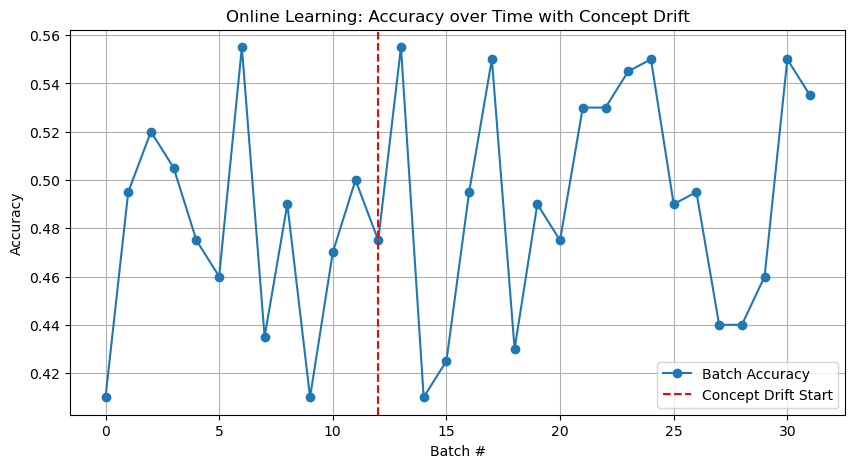

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies, marker='o', label="Batch Accuracy")
plt.axvline(x=drift_point // batch_size, color='r', linestyle='--', label="Concept Drift Start")
plt.title("Online Learning: Accuracy over Time with Concept Drift")
plt.xlabel("Batch #")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
